<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2018-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Alumno: <b>Fernando Antonio Barbeiro Campos</b> - <a>fbarbeiro@uoc.edu</a></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Combinación de clasificadores

En esta práctica veremos diferentes métodos de combinación de clasificadores aplicados sobre el conjunto de datos [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (ya usado en la práctica PEC 3).

<ol start="0">
  <li>Carga de datos</li>
  <li>Combinación paralela de clasificadores base similares
  <br>1.1 Bagging
  <br>. 1.1.1 Random Forest simple
  <br>. 1.1.2 Out-of-bag
  <br>. 1.1.3 Probabilidad por clase
  <br>. 1.1.4 Importancia de las variables
  <br>. 1.1.5 Número de clasificadores
  <br>. 1.1.6 Volumen de datos
  <br>1.2 Boosting</li>
  <li>Combinación secuencial de clasificadores base diferentes
  <br>2.1 Stacking
  <br>2.2 Cascading
  <br>. 2.2.1 Cascading simple
  <br>. 2.2.2 Cascading con variables adicionales</li>
</ol>

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# 0. Carga de datos

Usaremos los mismos datos que en la práctica anterior, PEC 3, que son las 5.000 imágenes Fashion MNIST, correspondientes a 5 tipos de prendas de ropa distintos: "T-shirt", "Trouser", "Pullover", "Dress" y "Coat".

El siguiente código cargará las imágenes y mostrará un ejemplo de imagen de cada una de las clases:

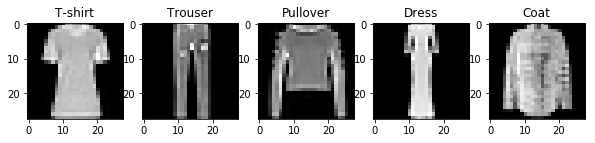

In [1]:
import pickle
import numpy as np

with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

In [2]:
# Metodo util para mostrar las clasificaciones incorrectas
import random
def print_wrong_classification (max_value, y_result_pred, pred_probab) :
    wrong_list = []

    if len(y_test) == len(y_result_pred):
        print("Tamaño igual de samples: " + str(len(y_test)))

        for i in range(len(y_test)):
            if y_test[i] != y_result_pred[i]:
                wrong_list.append({'Indice del error': i
                                   , 'Clasificación Equivocada': labels_text[y_result_pred[i]]
                                   , 'Clasificación Correcta': labels_text[y_test[i]]
                                  })
    print('La cantidad de errores es: ', len(wrong_list))


    fig, ax = plt.subplots(1, max_value, figsize=(25,25))

    for i in range(max_value):
        k = random.sample(wrong_list, 1)[0]
        print(k)
        #Using X_test instead of X_test_pca in order to view better images
        idx = k['Indice del error'] 
        legend = 'PROBABILITY:\n'
        for j in range(n_classes):
            legend += labels_text[j] + ': ' + str(pred_probab[idx][j]) + ('\n' if j<(n_classes - 1) else '')
        ax[i].imshow(X_test[idx].reshape(28, 28), cmap="gray")
        ax[i].set_title('Error: {}\nCor: {}'.format(k['Clasificación Equivocada'], k['Clasificación Correcta']))
        ax[i].text(7, 45, legend, bbox={'facecolor': 'white', 'pad': 3})
    
    return wrong_list

Tal como en la PEC 3, reducimos dimensionalidad usando PCA:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=2017, stratify=labels)

pca = PCA(n_components=100, random_state=2017)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)

# 1. Combinación paralela de clasificadores base similares

## 1.1 Bagging

### 1.1.1 Random forest simple (1 punto)

La idea básica del *bagging* es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo *Random Forest*, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (la *Random Forest*) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Usando los conjuntos *X_train_pca* e *y_train*, entrenar un modelo *Random Forest* con 100 árboles de decisión y estimar la precisión del modelo con una estrategia de *cross-validation* en los mismos conjuntos.
<hr>
    
Sugerencia: usar los módulos *RandomForestClassifier* y *cross_val_score* de sklearn. Para aprender más sobre *cross validation* y sobre como usar estes módulos, os recomendamos los siguientes enlaces:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>
http://scikit-learn.org/stable/modules/cross_validation.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def random_forest_cross_val_score( X, Y, n_estimators = 100):
    clf = RandomForestClassifier(n_estimators = 100)
    model = clf.fit(X, Y)

    precision = cross_val_score(model, X, Y, scoring = 'precision_macro', cv = 5)
    print('Precisión (Macro): \t%.4f' % np.mean(precision))
    return precision, model
    
precision_rf, model_rf = random_forest_cross_val_score(X = X_train_pca, Y = y_train)

Precisión (Macro): 	0.8586


### 1.1.2 Out-of-bag (1 punto)

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), o sea que cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Usando los conjuntos *X_train_pca* e *y_train*, entrenar un modelo Random Forest con 100 árboles de decisión. Mostrar la precisión de este modelo en el *out-of-bag* y en el conjunto *X_test_pca*.
<hr>
Sugerencia: usar el módulo *RandomForestClassifier* de sklearn. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br>
http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
</div>

In [5]:
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier(n_estimators = 100, oob_score = True)

# Train model
model     = randomforest.fit(X_train_pca, y_train)
predicted = randomforest.predict(X_test_pca)
accuracy  = accuracy_score(y_test, predicted)

print('Out-of-bag Score:  \t%.4f' % randomforest.oob_score_)
print('Mean accur. Score: \t%.4f' % accuracy)

Out-of-bag Score:  	0.8520
Mean accur. Score: 	0.8530


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> La precisión obtenida en el *out-of-bag* y en el conjunto de test son comparables? Era de esperar? 
</div>

Son comparables (y tras ejecutar algunas veces, los resultados suelen ser bastante parecidos en todas las ejecuciones).

Según define [1] **Albon, C. (2018)** en el *Out-of-bag* para cada observación, el algoritmo de aprendizaje compara el verdadero valor de la observación con la predicción de un subconjunto de árboles que no están entrenados para usar esa observación. La puntuación general se calcula y proporciona una medida única del rendimiento del RandomForest. 
Con esto, la estimación de la puntuación OOB es una alternativa más rápida a la validación cruzada y por lo tanto era de se esperar que tuviera una precisión adecuada y comparable con la predicción.

### 1.1.3 Probabilidad por clase (1 punto)

Otra ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión, entrenado con una combinación diferente de los datos, puede obtener un resultado diferente. En los problemas de clasificación, el resultado de cada árbol se considera como un voto diferente, y la predicción final del modelo es la clase que haya obtenido más votos teniendo en cuenta todos los árboles.

Estos votos individuales de los árboles también se pueden usar para estimar la probabilidad con la que el modelo prevé cada una de las clases, siendo la probabilidad para cada clase igual al número de votos obtenidos para aquella clase dividido entre el número de árboles.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Para cada clase (etiqueta), muestra un ejemplo de imágen que el modelo haya clasificado incorrectamente junto con la etiqueta asignada por el modelo y la etiqueta original. Muestra también las probabilidades que el modelo ha atribuído a cada clase para estas imágenes.
<hr> Sugerencia: usa el modelo que entrenaste en el ejercicio anterior con el módulo *RandomForestClassifier* de sklearn y las previsiones que calculaste para el conjunto de datos de test. Para mostrar las imágenes, usa el código proporcionado en la sección 0. Para aprender más sobre el módulo *RandomForestClassifier* de sklearn (incluyendo el método *predict_proba*), os recomendamos el siguiente enlace:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

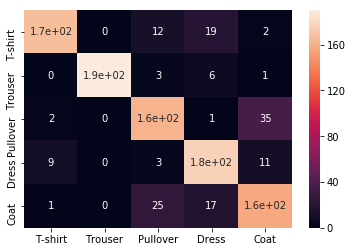

In [6]:
# Antes, voy a mostrar la matriz de confusion
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=labels_text, index=labels_text)
sns.heatmap(cm, annot=True)

Tamaño igual de samples: 1000
La cantidad de errores es:  147
{'Indice del error': 940, 'Clasificación Equivocada': 'T-shirt', 'Clasificación Correcta': 'Dress'}
{'Indice del error': 370, 'Clasificación Equivocada': 'Dress', 'Clasificación Correcta': 'T-shirt'}
{'Indice del error': 562, 'Clasificación Equivocada': 'Pullover', 'Clasificación Correcta': 'T-shirt'}
{'Indice del error': 543, 'Clasificación Equivocada': 'Pullover', 'Clasificación Correcta': 'Coat'}
{'Indice del error': 978, 'Clasificación Equivocada': 'Coat', 'Clasificación Correcta': 'Pullover'}
{'Indice del error': 158, 'Clasificación Equivocada': 'Dress', 'Clasificación Correcta': 'T-shirt'}
{'Indice del error': 582, 'Clasificación Equivocada': 'Pullover', 'Clasificación Correcta': 'Coat'}
{'Indice del error': 528, 'Clasificación Equivocada': 'Coat', 'Clasificación Correcta': 'Pullover'}


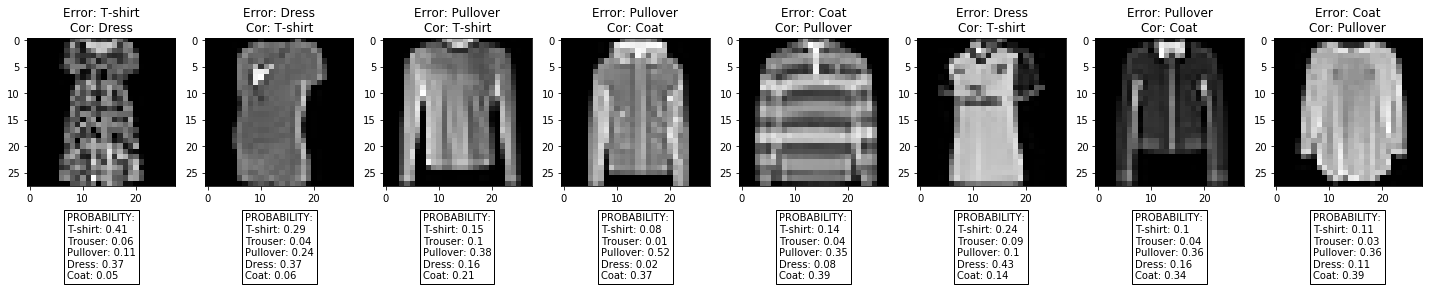

In [7]:
max_value = 8
probs = model.predict_proba(X_test_pca)
wrong_predictions = print_wrong_classification(max_value, predicted, probs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> En estos casos en los que el modelo se equivocó, estaba cerca de prever la etiqueta correcta?
</div>

En la realidad sí, **siempre que hubo equivocos, el modelo estaba bastante cerca de obtener la etiqueta correcta**. Hay casos que identificamos arriba donde el error ocurrió por **0.01** o **0.02**.
Obviamente, ni todos los escenarios fueran tan asertivos así, sin embargo, en la mayoria de ellos, la segunda categoría con más probabilidad era justo la categoría adecuada del target.

### 1.1.4 Importancia de las variables (1 punto)

Otra ventaja del algoritmo *Random Forest* es que permite medir la importancia relativa de cada variable, gracias a que cada uno de los árboles fué entrenado con un subconjunto diferente de las variables originales.

En el problema de clasificación de imágenes analizado aquí, la importancia de las variables nos permite saber cuáles son generalmente los píxeles más importantes par poder clasificar la imágen. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Entrena un clasificador *Random Forest* con el conjunto de datos de entrenamiento original *X_train*, en los que cada variable es la intensidad de cada píxel (en vez de ser las variables PCA que usamos anteriormente). Muestra cuáles son las 10 variables más importantes. Haz un gráfico en el que se vea que zonas de una imágen son más importantes para el clasificador.

<hr> Sugerencia: usa el módulo *RandomForestClassifier* de sklearn para calcular la importancia de las variables. Para representar gráficamente la importancia de cada píxel de la imagen, usa parte del código proporcionado en la sección 0. Para aprender más sobre el módulo *RandomForestClassifier* de sklearn (incluyendo el método *feature&#95;importances_*), os recomendamos el siguiente enlace:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

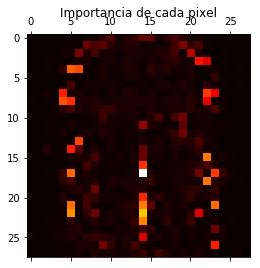

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)
model = randomforest.fit(X_train, y_train)

importances = model.feature_importances_
importances = importances.reshape(images[0].reshape(28, 28).shape)

# Plot pixel importances
plt.matshow(importances, cmap = plt.cm.hot)
plt.title("Importancia de cada pixel")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Te parece plausible el resultado que has obtenido? Porqué?
</div>

Sí, parece **bastante plausible**, especialmente porque los *features* de más importancia se encuentran **en los bordes** de las piezas de ropa, es decir el algoritmo ha identificado como mejor forma de clasificar los pixels más relevantes que ayudan a definir una especie de **silueta** de las piezas.

### 1.1.5 Número de clasificadores (1 punto)

En los ejercicios anteriores hemos combinado 100 clasificadores simples en nuestro clasificador combinado. Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Mientras que la búsqueda de rejilla nos permite encontrar la combinación de parámetros que da mejores resultados, la curva de validación nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Entrena varios modelos de *Random Forest* con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<hr>
Sugerencia: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

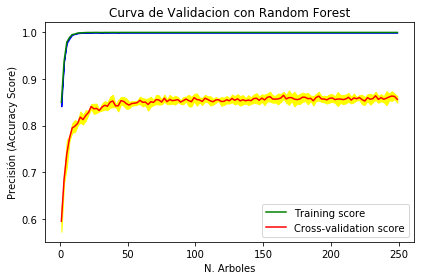

In [9]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    X_train_pca,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="yellow")

plt.title("Curva de Validacion con Random Forest")
plt.xlabel("N. Arboles")
plt.ylabel("Precisión (Accuracy Score)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Incrementa indefinidamente la precisión con el número de árboles combinados? Si satura, lo hace a la precisión máxima o a otro valor? Porqué?
</div>

**No, no se incrementa indefinidamente.**

Dicho, podemos observar en la representación gráfica arriba que hay cambios realmente grandes en la precisión cuando el número de árboles está entre **0 hasta ~30 o 40**, después la tendencia sigue bastante estable.

### 1.1.6 Volumen de datos (1 punto)

Será que entrenando el modelo con más datos (más imágenes) el modelo aprendería a clasificar con mejor precisión? Es muy útil intentar responder a esta pregunta antes de lanzarse a conseguir más datos, ya que este puede ser un proceso difícil, caro, o que implique esperar mucho tiempo.

Para responder a esta pregunta, analizaremos cómo evoluciona la precisión del modelo en los conjuntos de entrenamiento y test para diferentes volúmenes de datos de creciente tamaño. Representar los resultados en una curva de aprendizaje (*learning curve*) nos permitirá analizar visualmente estas cantidades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Entrena varios modelos de *Random Forest* con un volumen de datos cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de entrenamiento y de test, y representa los resutados en un gráfico.
<hr>
Sugerencia: usar el módulo *learning_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
</div>

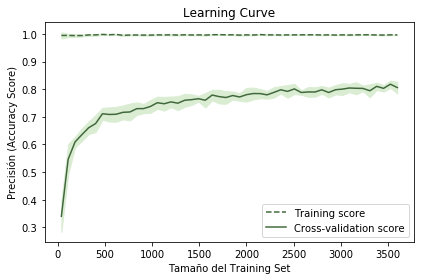

In [10]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train_pca, y_train, cv=10, scoring='accuracy',n_jobs=-1,train_sizes=np.linspace(0.01,1.0,50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#41683c",  label="Training score")
plt.plot(train_sizes, test_mean, color="#41683c", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#daedd3")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#daedd3")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Tamaño del Training Set"), plt.ylabel("Precisión (Accuracy Score)"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Crees que si obtuviésemos más datos de entrenamiento (más imágines clasificadas) mejoraría el modelo? Porqué?
</div>

Como ya ha sido explicado en el enunciado, la aproximación con *learning curve* se utiliza comúnmente para determinar si nuestros algoritmos de aprendizaje se beneficiarían de la recopilación de datos de training adicionales.

En nuestro ejemplo, trazamos la precisión de un `RandomForestClassifier` en 50 tamaños diferentes de conjuntos de entrenamiento que van desde el 1% de las observaciones hasta el 100%. 

El aumento en la puntuación de precisión de los modelos con cross-validation nos dice que **probablemente nos beneficiaríamos de observaciones adicionales**.

## 1.2 Boosting (1 punto)

En el sistema de *Boosting* se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Usando el conjunto *X_train_pca*, entrena un modelo Gradient Boosting y estima la precisión del modelo con una estrategia de *cross-validation* en los mismos conjuntos. Seguidamente calcula las previsiones del modelo en el conjunto *X_test_pca* y su precisión en este conjunto.

<hr>
Sugerencia: usar los módulos *GradientBoostingClassifier* y *cross_val_score* de sklearn. Para aprender a usar este módulo os recomendamos el siguientes enlace:<br>
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb = GradientBoostingClassifier()
gb.fit(X_train_pca, y_train)

# en la version de cross_val_score que utilizo, cv default es 3-fold por lo tanto, mostrará 3 estimativas
precision = cross_val_score(gb, X_train_pca, y_train)
print('Precisión estimada del modelo: ', precision)

pred_test = gb.predict(X_test_pca)
print('Precisión en el conjunto de test (X_test_pca): ', accuracy_score(pred_test, y_test))

# Otra posible aproximación que podría exhibir un report de la clasificación
#print(classification_report(y_true = y_test, y_pred = gb.predict(X_test_pca)))

Precisión estimada del modelo:  [0.85168539 0.86367041 0.84586466]
Precisión en el conjunto de test (X_test_pca):  0.862


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> El boosting se basa en la combinación de clasificadores débiles. En la implementación que utilizaste en este ejercicio, cuál es la profundidad de los árboles utilizados? Compárala con la que utilizaste en los árboles de decisión del ejercicio de *bagging*.
</div>

In [12]:
grad_boost = []

for estimator in gb.estimators_ :
    for dec_tree in estimator :
        grad_boost.append(dec_tree.tree_.max_depth)
print('Profundidades GradientBoostingClassifier: ', grad_boost)
print('Profundidades RandomForestClassifier:', [estimator.tree_.max_depth for estimator in model_rf.estimators_])

Profundidades GradientBoostingClassifier:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Como podemos observar, el `GradientBoostingClassifier` mantuvo el `max_depth` constante, mientras los otros (he probado con `clf` y también con `randomforest`) presentan una variación y una profundidad más grande.

# 2. Combinación secuencial de clasificadores base diferentes

## 2.1 Stacking (1 punto)

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

Para construir nuestro clasificador de *stacking* vamos a usar las predicciones hechas en el conjunto de test por los clasificadores:
- utilizados en los ejercicios anteriores en la PEC 4
- los utilizados en la PEC 3 (K-Nearest neighbors Classifier (knc), Support Vector Machines Classifier (svmc) y Neural Network Classifier (nnc))
- Discriminant Analysis (dac)

los dos últimos os los damos en archivos adjuntos. Estas predicciones se pueden cargar con el siguiente código: 

In [13]:
# carga de predicciones calculadas en el PEC3:
preds_knc = np.load("preds_knc.pickle")
preds_svmc = np.load("preds_svmc.pickle")
preds_nnc = np.load("preds_nnc.pickle")
# carga de las predicciones por un modelo de Discriminant Analysis:
preds_dac = np.load("preds_dac.pickle")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Construye un clasificador de *stacking* usando una *Random Forest* que use como atributos a las predicciones hechas en el conjunto de test por los algoritmos k-nn, SVM, red neuronal y  Gradient Boosting. Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<hr>
Sugerencia: usar las funciones column_stack de numpy y OneHotEncoder de sklearn para preparar los datos. Para aprender a usar estas funciones  os recomendamos los siguientes enlaces:<br>
https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html<br>
http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
</div>

In [14]:
from numpy import column_stack
from sklearn.preprocessing import OneHotEncoder

preds_gradient_boost = pred_test

without_dac = column_stack((preds_knc, preds_svmc, preds_nnc, preds_gradient_boost))
with_dac = column_stack((preds_knc, preds_svmc, preds_nnc, preds_gradient_boost, preds_dac))


onehot_encoder = OneHotEncoder(sparse=False)
without_dac_bin = onehot_encoder.fit_transform(without_dac)
with_dac_bin = onehot_encoder.fit_transform(with_dac)


prec1, model1 = random_forest_cross_val_score(X = without_dac_bin, Y = y_test)
prec2, model2 = random_forest_cross_val_score(X = with_dac_bin, Y = y_test)


Precisión (Macro): 	0.8810
Precisión (Macro): 	0.8920


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al *stacking*? Comenta el resultado.
</div>

Si consideramos los resultados que obtuvimos inicialmente en el apartado **1.1.1 Random forest simple** con los que hemos obtenido ahora, podemos comparar una diferencia de unos **3-4% de mejora gracias al** *stacking*.

La verdad es que ya teníamos un modelo significativamente bueno en la aproximación inicial (**sobre los 85% de precisión**) y con los cambios para utilizar *stack*, tuvimos la mejora mencionada antes. 

Aparte, como es posible observar en el código arriba, *he probado 2 distintas soluciones*, con y sin las predicciones de *Discriminant Analysis*, y en los resultados finales, donde hemos utilizado dac hubo una performance un poco mejor en el sentido de la precisión.


## 2.2 Cascading

### 2.2.1 Cascading simple (1 punto)

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Construye un clasificador de *cascading* usando una *Random Forest* que use como atributos a las predicciones hechas en el conjunto de test por los algoritmos k-nn, SVM, red neuronal y  Gradient Boosting, así como también las variables originales. Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<hr>
Sugerencia: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade el conjunto de test original *X_test_pca*.
</div>

In [15]:
final_no_dac = np.concatenate((without_dac_bin, X_test_pca), axis=1)
final_with_dac = np.concatenate((with_dac_bin, X_test_pca), axis=1)
prec1, model1 = random_forest_cross_val_score(X = final_no_dac, Y = y_test)
prec2, model2 = random_forest_cross_val_score(X = final_with_dac, Y = y_test)

Precisión (Macro): 	0.8816
Precisión (Macro): 	0.8871


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al *cascading*? Comenta el resultado.
</div>

Desde mi punto de vista, obviamente hemos mejorado un poco la performance mientras comparamos con la versión original de random forest simple, sin embargo, si comparamos con la versión de stacking, la performance (precisión) es bastante similar no presentando diferencias considerables.

### 2.2.2 Cascading con variables adicionales (1 punto)

En el *cascading* también podemos añadir como variables del modelo a datos adicionales que se hayan podido generar durante la toma de decisiones de los clasificadores que combinamos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Qué datos adicionales de los modelos anteriores podrías usar para enriquecer al modelo? Construye un clasificador de *cascading* usando una *Random Forest* que use como atributos a los usados en el ejercicio anterior más otros que puedas obtener de algunos de los clasificadores utilizados en los ejercicios anteriores. Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.
</div>

In [16]:
# Datos adicionales que tengo la intencion de añadir
preds_boosting = pred_test
preds_rf_oob = predicted

aux1 = column_stack((preds_knc, preds_svmc, preds_nnc, preds_gradient_boost, preds_boosting, preds_rf_oob))
aux2 = column_stack((preds_knc, preds_svmc, preds_nnc, preds_gradient_boost, preds_dac, preds_boosting, preds_rf_oob))

casc_add_var_no_dac = np.concatenate((aux1, X_test_pca), axis=1)
casc_add_var_dac = np.concatenate((aux2, X_test_pca), axis=1)

prec1, model1 = random_forest_cross_val_score(X = casc_add_var_no_dac, Y = y_test)
prec2, model2 = random_forest_cross_val_score(X = casc_add_var_dac, Y = y_test)

Precisión (Macro): 	0.8791
Precisión (Macro): 	0.8784


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Has conseguido mejorar la precisión gracias a añadir datos adicionales al *stacking*? Comenta el resultado.
</div>

Con la intención de sacar un modelo mejor, he intentado añadir a dos columnas con resultados de las predicciones de modules de otros apartados de la PEC, fueron ellas: predicción de boosting y random forest con análisis de out-of-bag.

En lo que se refiere a precisión, los resultados han sido practicamente los mismos, o sea, no he logrado de concluir una mejora de aplicar las variables adicionales en el cascading.

## Referencias

[1] **Alban, C. (2018)**. *Machine Learning with Python Cookbook*. O'Reilly Media, Inc.